In [1]:
import torch
import torchvision
import torchvision.models as models
from torchvision.transforms import v2
from torch.utils.data import Dataset, DataLoader

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, precision_recall_fscore_support, confusion_matrix, roc_auc_score, roc_curve, precision_recall_curve, auc

In [3]:
import os
import cv2
import numpy as np
import lmdb
import pickle

In [4]:
from src.FFTConv import *
from src.ImageHandler import *

In [5]:
IMG_SIZE = 128
device = 'cuda' if torch.cuda.is_available() else 'cpu'
REBUILD_DATA = False

In [6]:
lmdb_path = os.path.join('lmdb')

if REBUILD_DATA:
    image_path = os.path.join('data', 'test_set')
    test_data = ImageDataset(image_path=image_path, device=device, lmdb_path=lmdb_path, save_lmdb=True, mode="test")

    REBUILD_DATA = False
else:
    test_data = ImageDataset(image_path=None, device=device, lmdb_path=lmdb_path, save_lmdb=False, mode="test")

Loaded test dataset


In [7]:
batch_size = 32
test_dl = DataLoader(test_data, batch_size, shuffle=False, pin_memory=True)

In [8]:
fft_alex = FFTAlex(apply_fft=True, device=device, IMG_SIZE=IMG_SIZE)
reg_alex = FFTAlex(apply_fft=False, device=device, IMG_SIZE=IMG_SIZE)

Total Layers replaced:  1


In [9]:
fft_google = FFTGoogle(apply_fft=True, device=device)
reg_google = FFTGoogle(apply_fft=False, device=device)

Total Layers replaced:  18


In [10]:
fft_alex.load_model_dict(os.path.join('models', 'alex', 'fft_alex_model.pth'))
reg_alex.load_model_dict(os.path.join('models', 'alex', 'reg_alex_model.pth'))

C:\Users\samir\python\minor_project\fft_cnn\src\FFTConv.py:95: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(path, map_location=self.device)


In [11]:
fft_google.load_model_dict(os.path.join('models', 'google', 'fft_google_model.pth'))
reg_google.load_model_dict(os.path.join('models', 'google', 'reg_google_model.pth'))

In [12]:
tr_fft_alex = np.load(os.path.join('models', 'alex', 'tr_fft_accuracy.npy'))
val_fft_alex = np.load(os.path.join('models', 'alex', 'val_fft_accuracy.npy'))

tr_reg_alex = np.load(os.path.join('models', 'alex', 'tr_reg_accuracy.npy'))
val_reg_alex = np.load(os.path.join('models', 'alex', 'val_reg_accuracy.npy'))

In [13]:
tr_fft_google = np.load(os.path.join('models', 'google', 'tr_fft_accuracy.npy'))
val_fft_google = np.load(os.path.join('models', 'google', 'val_fft_accuracy.npy'))

tr_reg_google = np.load(os.path.join('models', 'google', 'tr_reg_accuracy.npy'))
val_reg_google = np.load(os.path.join('models', 'google', 'val_reg_accuracy.npy'))

In [14]:
def get_predictions(model, test_dl, device):
    model.eval()
    all_preds = []
    all_labels = []
    all_probs = []

    with torch.no_grad():
        for images, labels in tqdm(test_dl):
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            preds = torch.argmax(outputs, dim=1)
            probs = torch.softmax(outputs, dim=1)
            
            all_preds.extend(preds.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    return np.array(all_labels), np.array(all_preds), np.array(all_probs)

In [15]:
def compute_metrics(ground_truths, predictions):
    precision, recall, f1, _ = precision_recall_fscore_support(ground_truths, predictions, average=None)
    return precision, recall, f1

In [16]:
def plot_metrics(precision1, recall1, f1_1, precision2, recall2, f1_2, class_names, save_path):
    x = np.arange(len(class_names))
    width = 0.3

    fig, ax = plt.subplots(1, 3, figsize=(15,5))

    # Precision
    ax[0].bar(x - width/2, precision1, width, label="Model 1", color="blue")
    ax[0].bar(x + width/2, precision2, width, label="Model 2", color="orange")
    ax[0].set_title("Precision Comparison")
    ax[0].set_xticks(x)
    ax[0].set_xticklabels(class_names)

    # Recall
    ax[1].bar(x - width/2, recall1, width, color="blue")
    ax[1].bar(x + width/2, recall2, width, color="orange")
    ax[1].set_title("Recall Comparison")
    ax[1].set_xticks(x)
    ax[1].set_xticklabels(class_names)

    # F1-score
    ax[2].bar(x - width/2, f1_1, width, color="blue")
    ax[2].bar(x + width/2, f1_2, width, color="orange")
    ax[2].set_title("F1-score Comparison")
    ax[2].set_xticks(x)
    ax[2].set_xticklabels(class_names)

    for a in ax:
        a.legend(["FFT", "Regular"])
        a.set_ylim(0, 1)

    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches="tight")
        
    plt.show()

In [17]:
def plot_confusion_matrix(y_true, y_pred1, y_pred2, class_names, save_path):
    cm1 = confusion_matrix(y_true, y_pred1)
    cm2 = confusion_matrix(y_true, y_pred2)

    fig, ax = plt.subplots(1, 2, figsize=(12, 5))

    sns.heatmap(cm1, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names, ax=ax[0])
    ax[0].set_title("Confusion Matrix - FFT")
    ax[0].set_xlabel("Predicted")
    ax[0].set_ylabel("Actual")

    sns.heatmap(cm2, annot=True, fmt="d", cmap="Oranges", xticklabels=class_names, yticklabels=class_names, ax=ax[1])
    ax[1].set_title("Confusion Matrix - Regular")
    ax[1].set_xlabel("Predicted")
    ax[1].set_ylabel("Actual")

    plt.tight_layout()
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches="tight")
    plt.show()

In [18]:
def plot_accuracy_graphs(
    model1_train_acc, model1_val_acc,
    model2_train_acc, model2_val_acc,
    num_epochs, save_path
):
    epochs = np.arange(1, num_epochs + 1)

    fig, ax = plt.subplots(2, 2, figsize=(12, 8))

    # FFT Training vs Validation
    ax[0, 0].plot(epochs, model1_train_acc, label="Train", marker="o", color="blue")
    ax[0, 0].plot(epochs, model1_val_acc, label="Validation", marker="s", color="red")
    ax[0, 0].set_title("FFT: Training vs Validation Accuracy")
    ax[0, 0].set_xlabel("Epochs")
    ax[0, 0].set_ylabel("Accuracy")
    ax[0, 0].legend()

    # Regular Training vs Validation
    ax[0, 1].plot(epochs, model2_train_acc, label="Train", marker="o", color="blue")
    ax[0, 1].plot(epochs, model2_val_acc, label="Validation", marker="s", color="red")
    ax[0, 1].set_title("Regular: Training vs Validation Accuracy")
    ax[0, 1].set_xlabel("Epochs")
    ax[0, 1].set_ylabel("Accuracy")
    ax[0, 1].legend()

    # FFT Validation vs Regular Validation
    ax[1, 0].plot(epochs, model1_val_acc, label="FFT", marker="o", color="blue")
    ax[1, 0].plot(epochs, model2_val_acc, label="Regular", marker="s", color="orange")
    ax[1, 0].set_title("Validation Accuracy: FFT vs Regular")
    ax[1, 0].set_xlabel("Epochs")
    ax[1, 0].set_ylabel("Accuracy")
    ax[1, 0].legend()

    # FFT Training vs Regular Training
    ax[1, 1].plot(epochs, model1_train_acc, label="FFT", marker="o", color="blue")
    ax[1, 1].plot(epochs, model2_train_acc, label="Regular", marker="s", color="orange")
    ax[1, 1].set_title("Training Accuracy: FFT vs Regular")
    ax[1, 1].set_xlabel("Epochs")
    ax[1, 1].set_ylabel("Accuracy")
    ax[1, 1].legend()

    plt.tight_layout()

    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches="tight")
    
    plt.show()

In [19]:
def plot_precision_recall_curve(y_true, y_pred_probs1, y_pred_probs2, class_names, save_path):
    """Plot Precision-Recall Curves for both models."""
    fig, ax = plt.subplots(1, len(class_names), figsize=(15, 5))
    if len(class_names) == 1:
        ax = [ax]  # Ensure iterable when there is only one class
    
    for i, class_name in enumerate(class_names):
        precision1, recall1, _ = precision_recall_curve(y_true == i, y_pred_probs1[:, i])
        precision2, recall2, _ = precision_recall_curve(y_true == i, y_pred_probs2[:, i])
        
        auc1 = auc(recall1, precision1)
        auc2 = auc(recall2, precision2)
        
        ax[i].plot(recall1, precision1, label=f"FFT (AUC={auc1:.2f})", color="blue")
        ax[i].plot(recall2, precision2, label=f"Regular (AUC={auc2:.2f})", color="orange")
        
        ax[i].set_title(f"Precision-Recall Curve: {class_name}")
        ax[i].set_xlabel("Recall")
        ax[i].set_ylabel("Precision")
        ax[i].legend()
    
    plt.tight_layout()

    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches="tight")
        
    plt.show()

In [20]:
def plot_roc_curve(y_true, y_probs, class_names, save_path):
    plt.figure(figsize=(10, 8))
    for i in range(y_probs.shape[1]):
        fpr, tpr, _ = roc_curve(y_true == i, y_probs[:, i])
        auc = roc_auc_score(y_true == i, y_probs[:, i])
        plt.plot(fpr, tpr, label=f'{class_names[i]} (AUC = {auc:.2f})')

    plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")

    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches="tight")
        
    plt.show()

In [21]:
def compare_models(model1, model2, test_dl, class_names, 
                   model1_train_acc, model1_val_acc,
                   model2_train_acc, model2_val_acc,
                   num_epochs, name,
                   device):
    y_true, y_pred1, y_probs1 = get_predictions(model1, test_dl, device)
    _, y_pred2, y_probs2 = get_predictions(model2, test_dl, device)

    precision1, recall1, f1_1 = compute_metrics(y_true, y_pred1)
    precision2, recall2, f1_2 = compute_metrics(y_true, y_pred2)

    print("\nFFT Metrics:\n", classification_report(y_true, y_pred1, target_names=class_names))
    print("\nRegular Metrics:\n", classification_report(y_true, y_pred2, target_names=class_names))

    plot_metrics(precision1, recall1, f1_1, precision2, recall2, f1_2, class_names, os.path.join('graphs', f'{name}', 'PRF.png'))
    plot_confusion_matrix(y_true, y_pred1, y_pred2, class_names, os.path.join('graphs', f'{name}', 'confusion.png'))
    plot_precision_recall_curve(y_true, y_probs1, y_probs2, class_names, os.path.join('graphs', f'{name}', 'PR_curve.png'))
    plot_accuracy_graphs(model1_train_acc, model1_val_acc, model2_train_acc, model2_val_acc, num_epochs, os.path.join('graphs', f'{name}', 'accuracy.png'))

    # Plot ROC curve for both models
    print("\nROC Curve for FFT Model:")
    plot_roc_curve(y_true, y_probs1, class_names, os.path.join('graphs', f'{name}', 'ROC_fft.png'))
    print("\nROC Curve for Regular Model:")
    plot_roc_curve(y_true, y_probs2, class_names, os.path.join('graphs', f'{name}', 'ROC_reg.png'))

In [22]:
class_names = ["bacterial", "normal", "viral"]

num_epochs_alex = len(tr_fft_alex)
num_epochs_google = len(tr_fft_google)

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 55.90it/s]



FFT Metrics:
               precision    recall  f1-score   support

   bacterial       0.86      0.96      0.90       242
      normal       0.97      0.75      0.85       234
       viral       0.66      0.77      0.71       148

    accuracy                           0.84       624
   macro avg       0.83      0.83      0.82       624
weighted avg       0.85      0.84      0.84       624


Regular Metrics:
               precision    recall  f1-score   support

   bacterial       0.79      0.94      0.86       242
      normal       0.96      0.77      0.86       234
       viral       0.65      0.66      0.65       148

    accuracy                           0.81       624
   macro avg       0.80      0.79      0.79       624
weighted avg       0.82      0.81      0.81       624



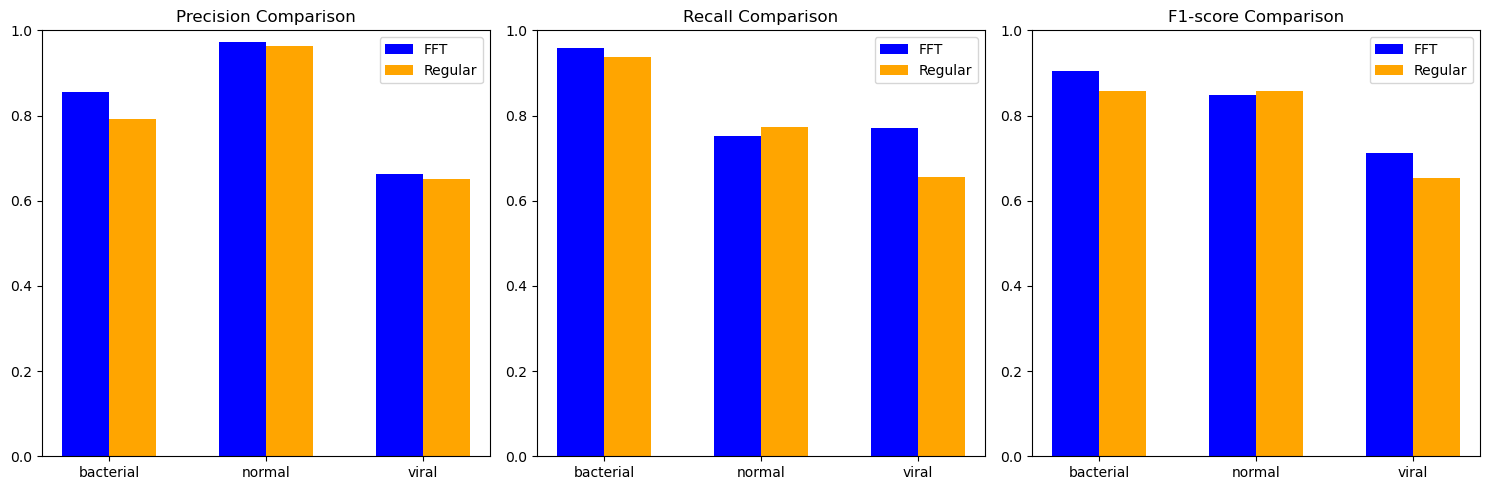

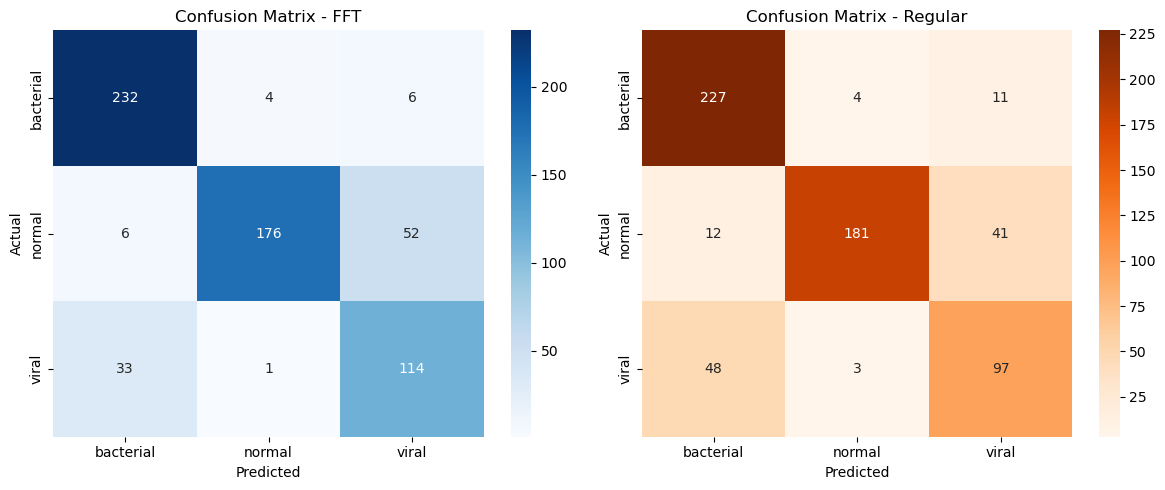

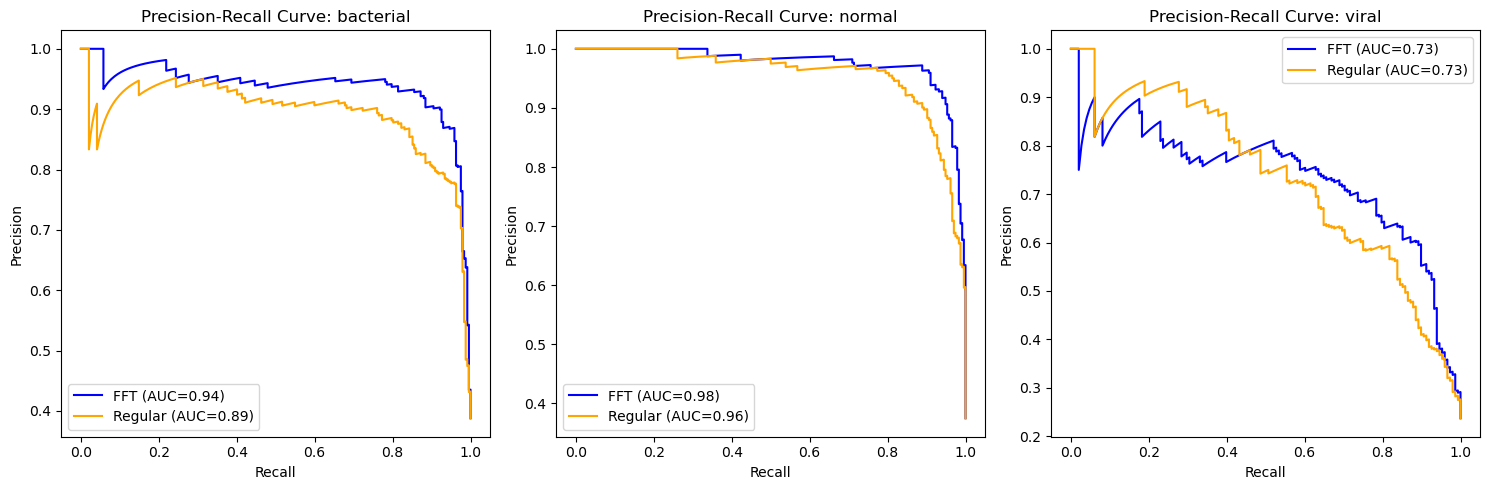

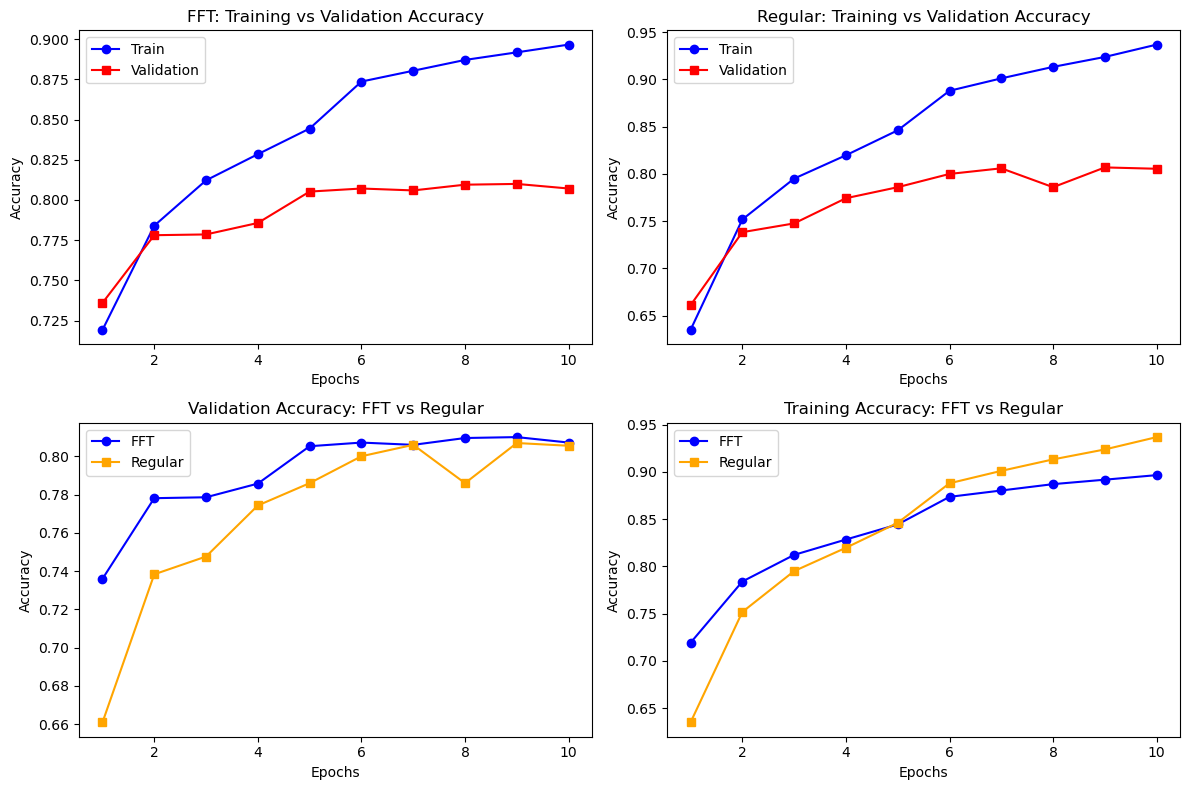


ROC Curve for FFT Model:


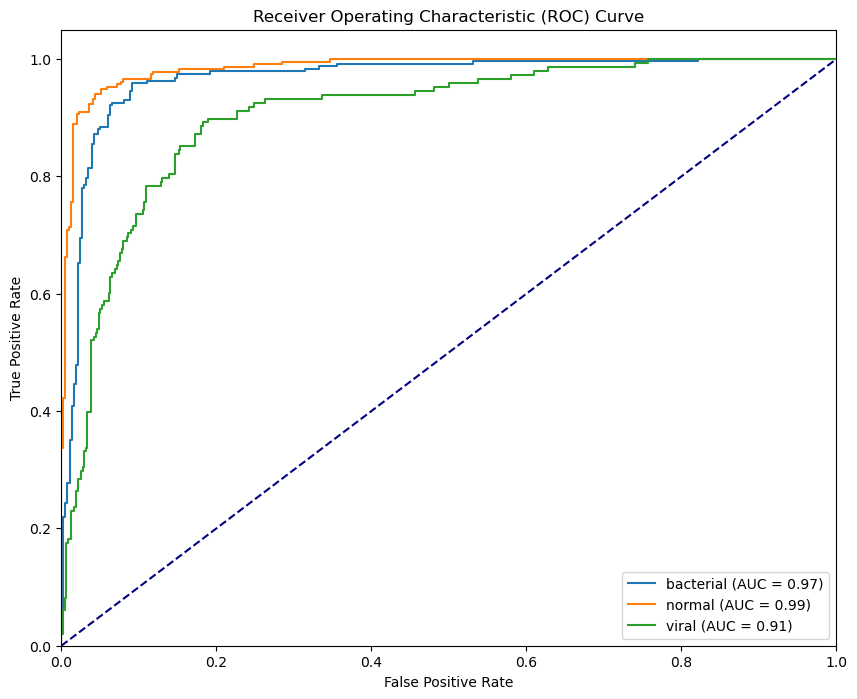


ROC Curve for Regular Model:


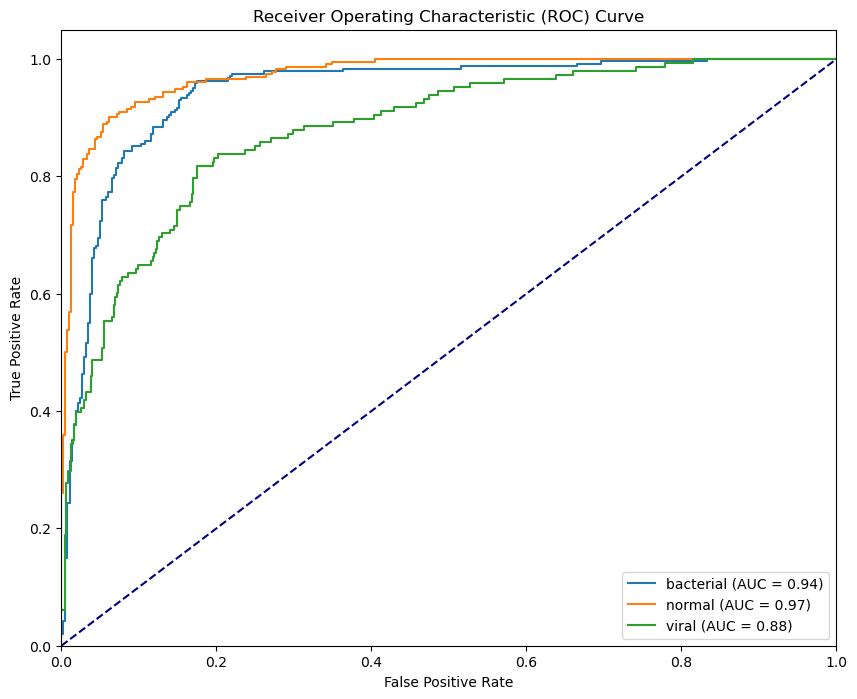

In [23]:
compare_models(fft_alex, reg_alex, test_dl, class_names,
               tr_fft_alex, val_fft_alex,
               tr_reg_alex, val_reg_alex, 
               num_epochs_alex, name='alex',
               device=device)

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 25.87it/s]



FFT Metrics:
               precision    recall  f1-score   support

   bacterial       0.84      0.93      0.88       242
      normal       0.97      0.71      0.82       234
       viral       0.63      0.78      0.69       148

    accuracy                           0.81       624
   macro avg       0.81      0.81      0.80       624
weighted avg       0.84      0.81      0.82       624


Regular Metrics:
               precision    recall  f1-score   support

   bacterial       0.81      0.93      0.86       242
      normal       0.97      0.69      0.81       234
       viral       0.60      0.74      0.66       148

    accuracy                           0.79       624
   macro avg       0.79      0.78      0.78       624
weighted avg       0.82      0.79      0.79       624



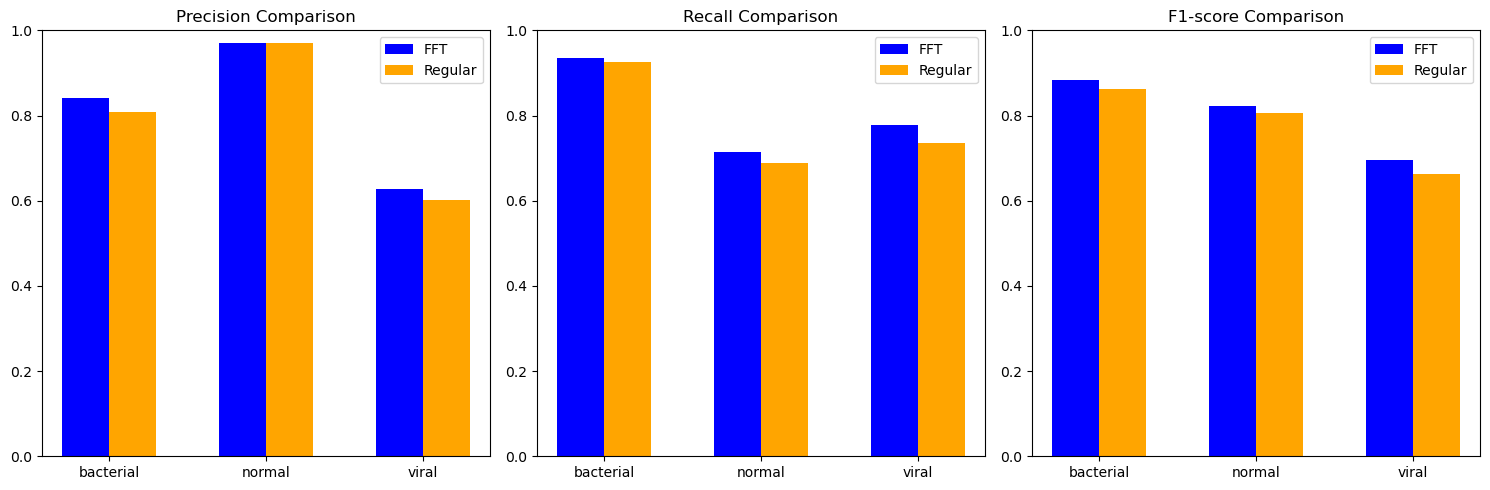

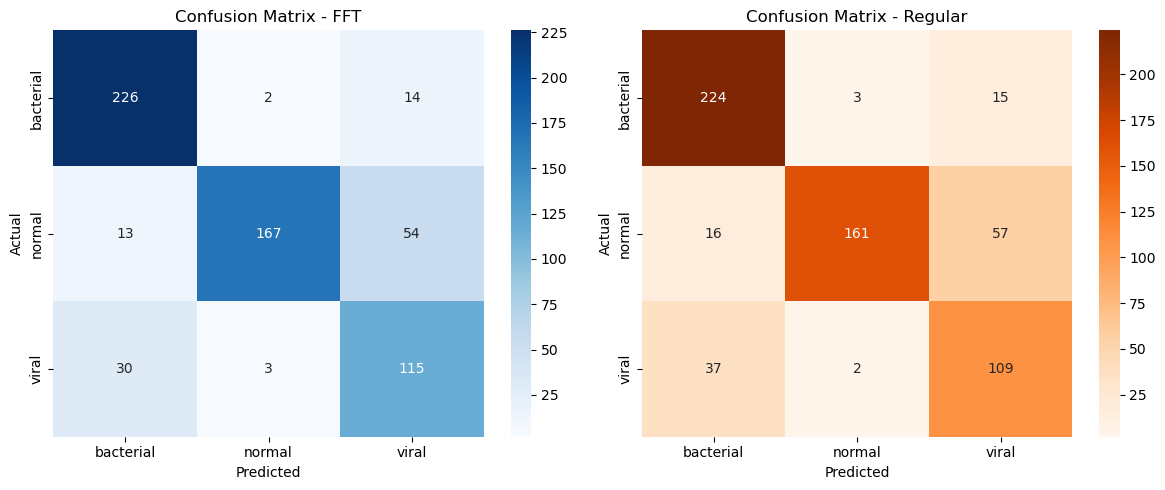

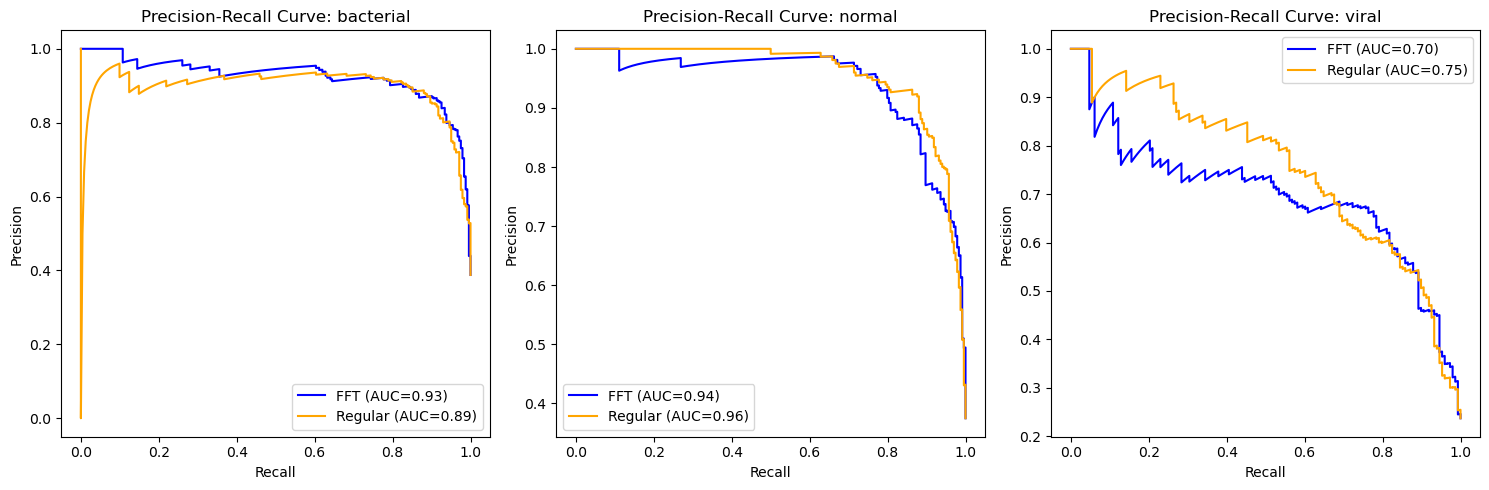

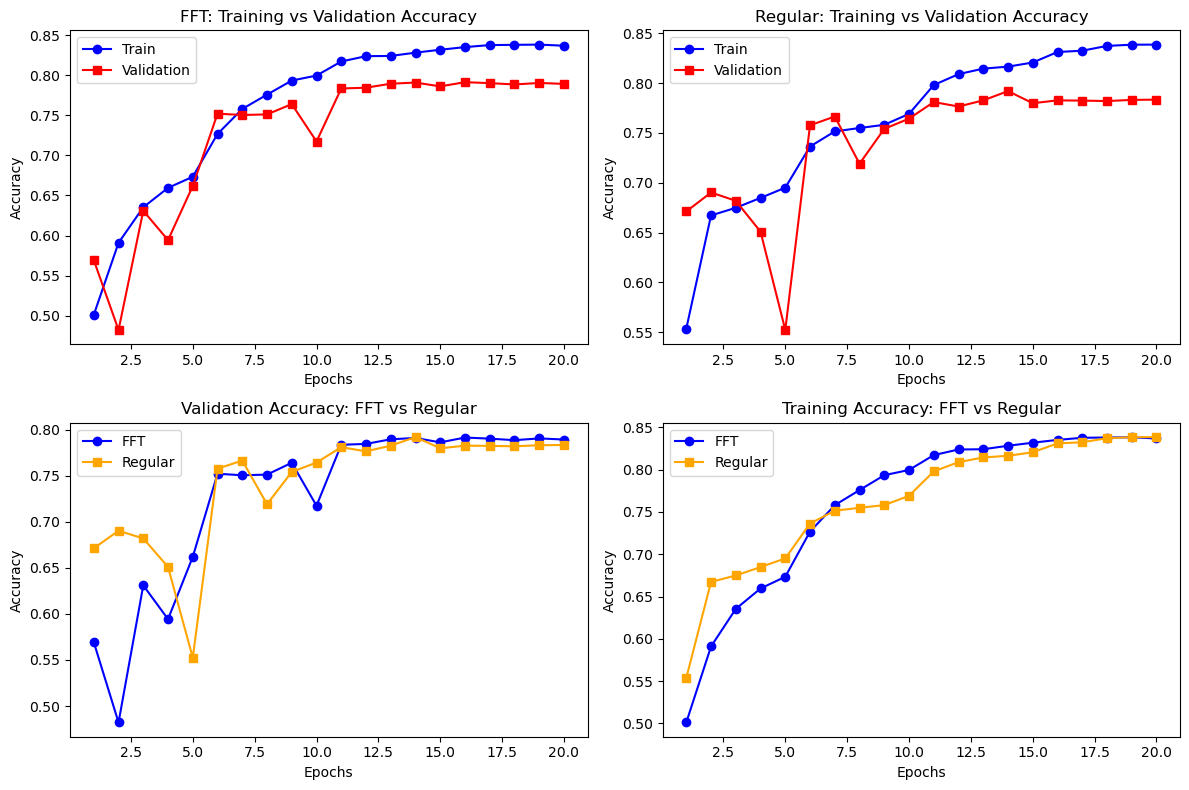


ROC Curve for FFT Model:


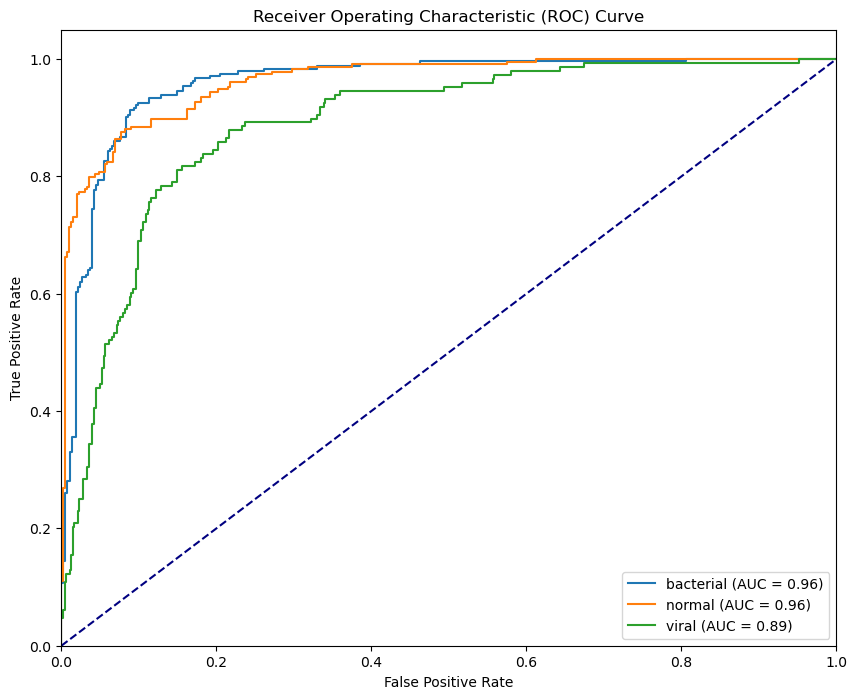


ROC Curve for Regular Model:


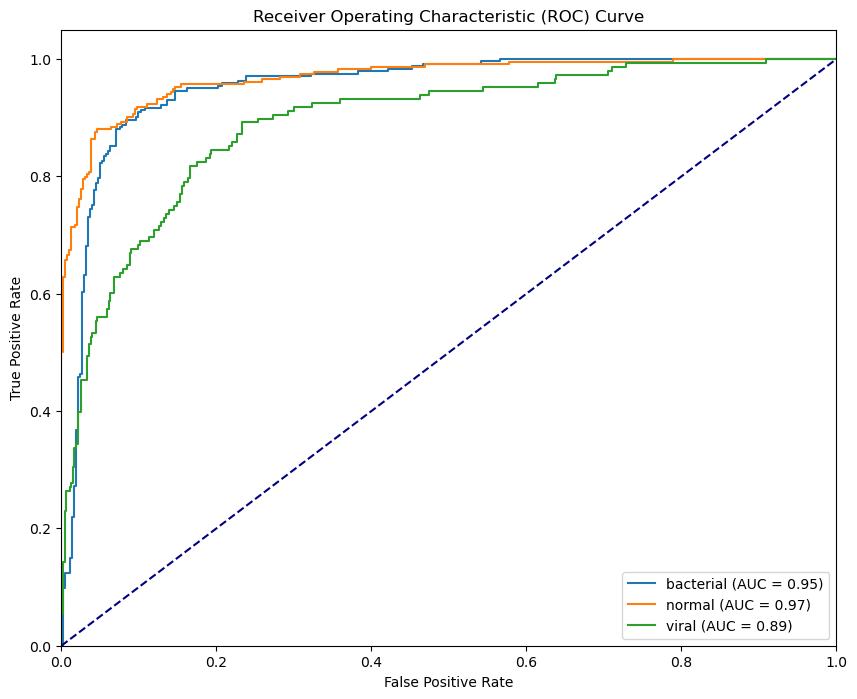

In [24]:
compare_models(fft_google, reg_google, test_dl, class_names,
               tr_fft_google, val_fft_google,
               tr_reg_google, val_reg_google, 
               num_epochs_google, name='google',
               device=device)